<a href="https://colab.research.google.com/github/rizalpangestu1/Machine-Learning/blob/main/GymLens_Training_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [9]:
# Mount Google Drive
drive.mount('/content/drive')
# Dataset directory
DATASET_DIR = '/content/drive/MyDrive/C242-PS284/Gym Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


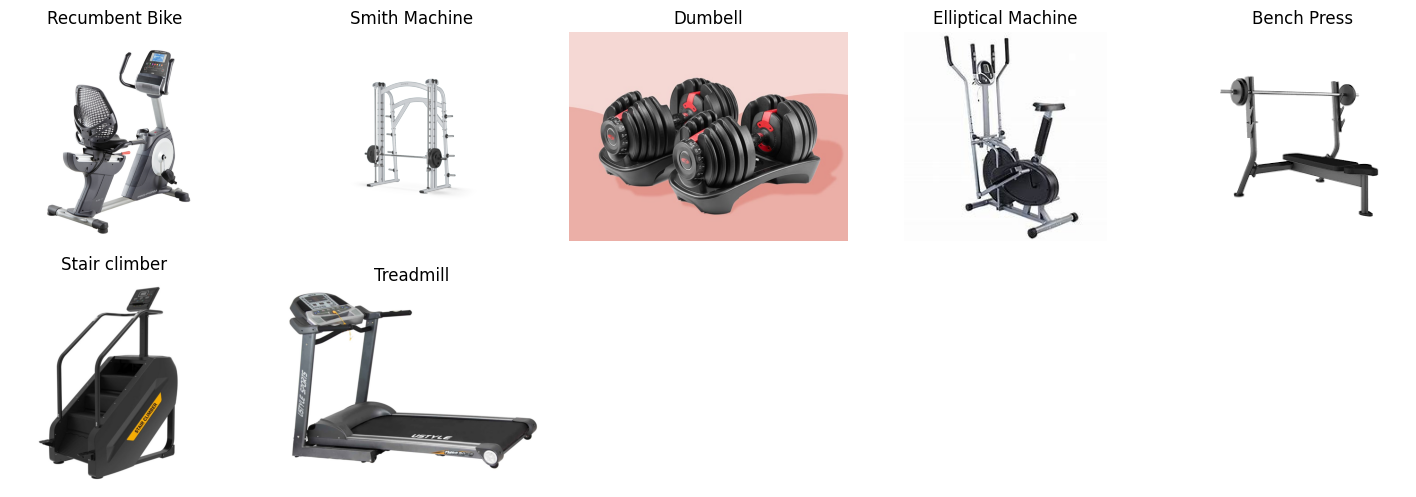

In [10]:
# Function to preprocess and handle images
def preprocess_image(image_path):
    """
    Open an image, convert to RGBA format if necessary, and return the processed image.
    """
    img = Image.open(image_path)
    if img.mode in ('P', 'L') or ('transparency' in img.info):
        img = img.convert('RGBA')
    return img

# Function to display sample images
def display_sample_images(data_dir, max_classes=19):
    """
    Display one sample image from each class in the dataset.
    """
    try:
        classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
        plt.figure(figsize=(15, 10))

        for i, cls in enumerate(classes[:max_classes]):
            cls_path = os.path.join(data_dir, cls)
            if os.path.isdir(cls_path):
                image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
                if image_files:
                    image_path = os.path.join(cls_path, image_files[0])
                    img = preprocess_image(image_path)

                    plt.subplot(4, 5, i + 1)
                    plt.imshow(img)
                    plt.title(cls)
                    plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error displaying images: {e}")

# Display sample images
display_sample_images(DATASET_DIR)


In [11]:
# Data Generators
batch_size = 128
train_datagen = ImageDataGenerator(
    validation_split=0.2,  # Split 20% for validation
    rescale=1.0 / 255,  # Normalize pixel values
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128, 128),  # Smaller input size for faster training
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

print("Number of classes:", len(train_generator.class_indices))
print("Number of training images:", train_generator.n)
print("Number of validation images:", validation_generator.n)


Found 1404 images belonging to 7 classes.
Found 347 images belonging to 7 classes.
Number of classes: 7
Number of training images: 1404
Number of validation images: 347


In [5]:
# Define the model using MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model to speed up training

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# EarlyStoppingCallback for accuracy >= 98%
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nStopping training as validation accuracy reached {val_acc:.2f} (≥ {self.target_accuracy:.2f})")
            self.model.stop_training = True

early_stopping = EarlyStoppingAtAccuracy(target_accuracy=0.98)

In [13]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Maximum epochs
    callbacks=[early_stopping]
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 201s 15s/step - accuracy: 0.6729 - loss: 1.2404 - val_accuracy: 0.7176 - val_loss: 1.3670
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.9105 - loss: 0.2650 - val_accuracy: 0.7579 - val_loss: 1.2004
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.9489 - loss: 0.1455 - val_accuracy: 0.7579 - val_loss: 1.2073
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.9615 - loss: 0.1265 - val_accuracy: 0.7839 - val_loss: 1.1489
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.9763 - loss: 0.0854 - val_accuracy: 0.7810 - val_loss: 1.0663
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.9794 - loss: 0.0670 - val_accuracy: 0.7666 - val_loss: 1.0780
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.9801 - loss: 0.0517 - val_accuracy: 0.7896 - val_loss: 0.9578
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9876 - loss: 0.0402 - val_accuracy: 0.8012 - val_los

In [14]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8033 - loss: 0.8079
Validation Loss: 0.7331355810165405
Validation Accuracy: 0.8097983002662659


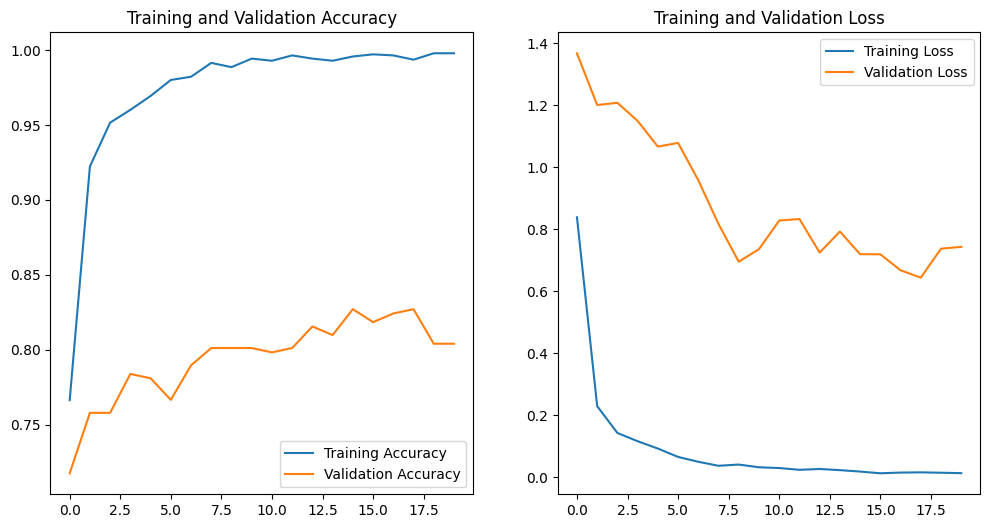

In [15]:
# Plot training history
def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss over epochs.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


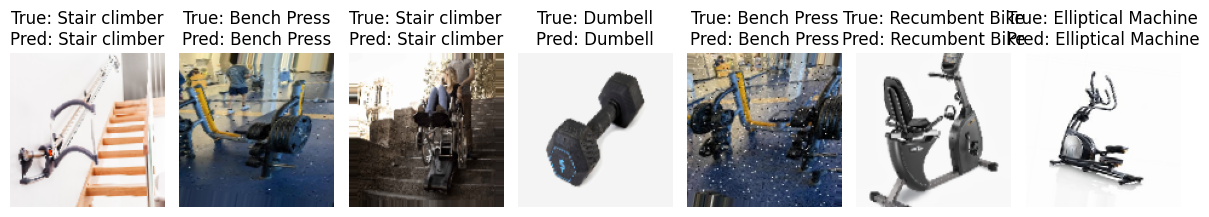

In [16]:
# Test with some validation images
def test_model_with_sample_images(validation_generator, model, num_samples=7):
    """
    Display predictions on sample validation images along with true labels.
    """
    # Get a batch of images and labels from the validation set
    images, labels = next(validation_generator)

    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = images[i]
        label = labels[i]

        # Predict the class of the image
        prediction = model.predict(img.reshape(1, *img.shape))
        predicted_label = list(validation_generator.class_indices.keys())[prediction.argmax()]
        true_label = list(validation_generator.class_indices.keys())[label.argmax()]

        # Display the image with the predicted and true labels
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on sample images
test_model_with_sample_images(validation_generator, model)

In [17]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/C242-PS284/saved_model/gym_model_MobileNetV2.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/C242-PS284/saved_model/gym_model_MobileNetV2.h5
